In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def gerar_ciclos(n_exemplos, min_n=3, max_n=15):
    grafos = []
    for _ in range(n_exemplos):
        n = np.random.randint(min_n, max_n + 1)
        G = nx.cycle_graph(n)
        grafos.append(G)
    return grafos


# --- GCN Layer ---
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, A_hat, X):
        return self.linear(torch.matmul(A_hat, X))

# --- VGAE ---
class VGAE(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2_mu = GCNLayer(hidden_dim, latent_dim)
        self.gcn2_logvar = GCNLayer(hidden_dim, latent_dim)

        self.decoder_fc1 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.decoder_fc2 = nn.Linear(latent_dim * 2, 1)

    def encode(self, A_hat, X):
        H = F.leaky_relu(self.gcn1(A_hat, X))
        mu = self.gcn2_mu(A_hat, H)
        logvar = self.gcn2_logvar(A_hat, H)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, Z):
        N = Z.size(0)
        rows = []
        for i in range(N):
            for j in range(N):
                z_ij = torch.cat([Z[i], Z[j]])
                h = F.leaky_relu(self.decoder_fc1(z_ij))
                out = torch.sigmoid(self.decoder_fc2(h))
                rows.append(out)
        return torch.stack(rows).view(N, N)

    def forward(self, A_hat, X):
        mu, logvar = self.encode(A_hat, X)
        Z = self.reparameterize(mu, logvar)
        A_pred = self.decode(Z)
        return A_pred, mu, logvar

# --- Treinamento ---
def preparar_adjacencia(G):
    A = nx.to_numpy_array(G)
    np.fill_diagonal(A, 1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(A.sum(axis=1) + 1e-10))
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32), torch.tensor(A, dtype=torch.float32)

In [76]:
grafos = gerar_ciclos(10000, 10, 25)
model = VGAE(in_dim=1, hidden_dim=8, latent_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for G in grafos:
        A_hat, A = preparar_adjacencia(G)
        N = A.shape[0]
        X = torch.ones((N, 1))  # Feature constante: h = 1

        A_pred, mu, logvar = model(A_hat, X)

        recon_loss = F.binary_cross_entropy(A_pred, A)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(grafos):.4f}")

KeyboardInterrupt: 

In [ ]:
model = VGAE(in_dim=1, hidden_dim=8, latent_dim=4)
model.load_state_dict(torch.load("cycle_torch.pth"))
model.eval() 

VGAE(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (gcn2_mu): GCNLayer(
    (linear): Linear(in_features=8, out_features=4, bias=True)
  )
  (gcn2_logvar): GCNLayer(
    (linear): Linear(in_features=8, out_features=4, bias=True)
  )
  (decoder_fc1): Linear(in_features=8, out_features=8, bias=True)
  (decoder_fc2): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
num_nos = 3  
latent_dim = 4  

Z_novos = torch.randn(num_nos, latent_dim) 

In [ ]:
with torch.no_grad():  
    A_pred = model.decode(Z_novos)  

In [ ]:
print(np.round(A_pred.numpy(), 2))

[[0.89 0.07 0.08]
 [0.09 0.88 0.13]
 [0.1  0.12 0.9 ]]


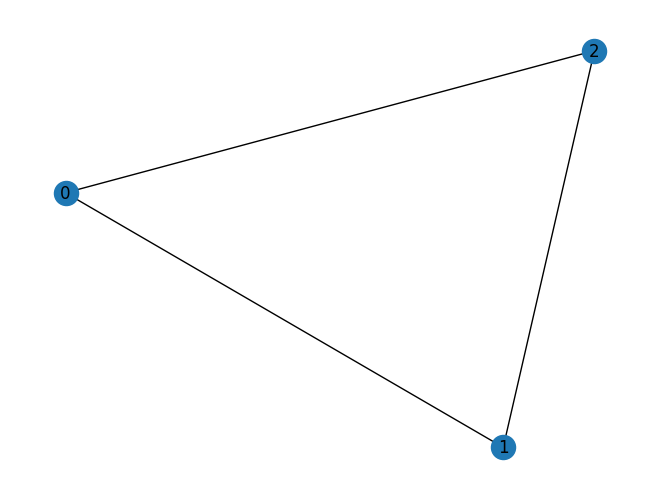

In [ ]:
threshold = 0.08
A_binaria = (A_pred > threshold).float() 
A_binaria.fill_diagonal_(0)

G_novo = nx.from_numpy_array(A_binaria.numpy()) 

nx.draw(G_novo, with_labels=True)
plt.show()

[[0.9  0.07 0.07 0.08]
 [0.06 0.89 0.05 0.17]
 [0.05 0.05 0.9  0.13]
 [0.06 0.15 0.15 0.9 ]]


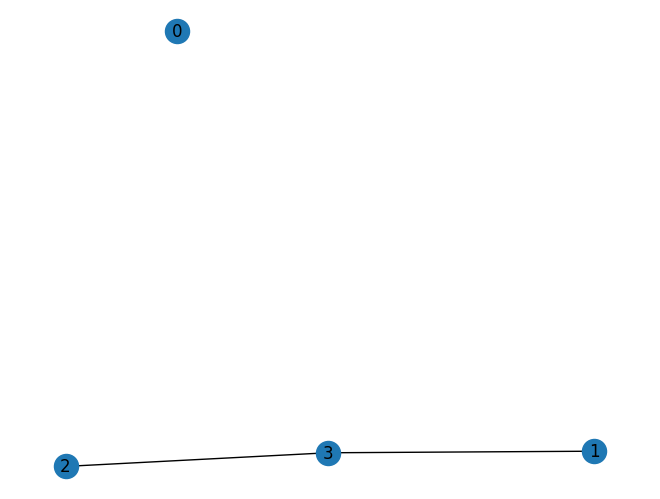

In [ ]:
num_nos = 4  
latent_dim = 4  

Z_novos = torch.randn(num_nos, latent_dim) 
with torch.no_grad():  
    A_pred = model.decode(Z_novos)  
print(np.round(A_pred.numpy(), 2))
threshold = 0.1
A_binaria = (A_pred > threshold).float() 
A_binaria.fill_diagonal_(0)

G_novo = nx.from_numpy_array(A_binaria.numpy()) 

nx.draw(G_novo, with_labels=True)
plt.show()

[[0.9  0.11 0.09 0.07 0.08 0.1  0.09 0.06]
 [0.11 0.9  0.11 0.08 0.09 0.14 0.11 0.07]
 [0.08 0.1  0.9  0.11 0.12 0.11 0.6  0.09]
 [0.05 0.06 0.1  0.89 0.12 0.07 0.1  0.11]
 [0.06 0.08 0.12 0.13 0.89 0.09 0.12 0.11]
 [0.09 0.11 0.12 0.09 0.1  0.9  0.12 0.08]
 [0.08 0.1  0.59 0.12 0.13 0.11 0.9  0.1 ]
 [0.04 0.05 0.08 0.11 0.1  0.06 0.08 0.88]]


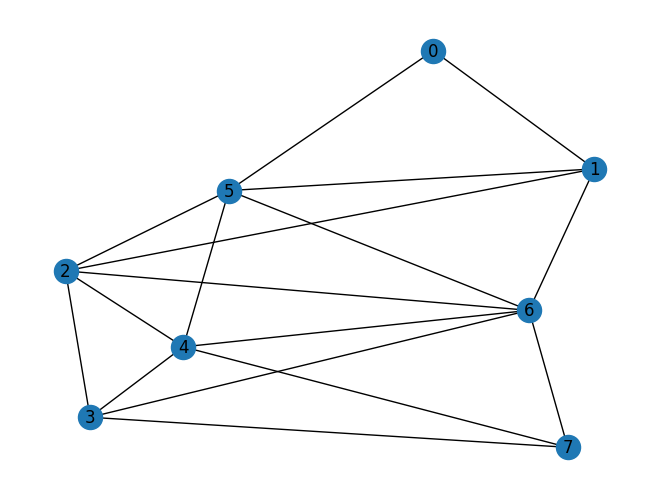

In [ ]:
num_nos = 8  
latent_dim = 4  

Z_novos = torch.randn(num_nos, latent_dim) 
with torch.no_grad():  
    A_pred = model.decode(Z_novos)  
print(np.round(A_pred.numpy(), 2))
threshold = 0.1
A_binaria = (A_pred > threshold).float() 
A_binaria.fill_diagonal_(0)

G_novo = nx.from_numpy_array(A_binaria.numpy()) 

nx.draw(G_novo, with_labels=True)
plt.show()